## Imports area

In [22]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Flags Definition

In [20]:
DATA_PATH = '../data/'
FINAL_DATAFRAME_LOC = '../data/consolidated_df.csv'

## Loading dataframes

In [3]:
streaming_movies = pd.read_csv(DATA_PATH + 'streaming_movies/MoviesOnStreamingPlatforms_updated.csv', sep=',')
the_oscar_awards = pd.read_csv(DATA_PATH + 'the_oscar_awards/the_oscar_award.csv', sep=',')

## Initial exploration / Data Processing

In [4]:
list(streaming_movies.columns)

['Unnamed: 0',
 'ID',
 'Title',
 'Year',
 'Age',
 'IMDb',
 'Rotten Tomatoes',
 'Netflix',
 'Hulu',
 'Prime Video',
 'Disney+',
 'Type',
 'Directors',
 'Genres',
 'Country',
 'Language',
 'Runtime']

In [5]:
list(the_oscar_awards.columns)

['year_film',
 'year_ceremony',
 'ceremony',
 'category',
 'name',
 'film',
 'winner']

#### Target Columns

In [6]:
"""

TITLE, 
YEAR, 
HULU, 
NETFLIX, 
DISNEY_PLUS, 
PRIME_VIDEO, 
COUNTRY, 
GENRES, 
DURATION, 
OSCAR_INDICATED, 
WON_OSCAR, 
IMDB,
AGE_CLASSIFICATION,
LANGUAGE,
MOVIE_AGE

"""

'\n\nTITLE, \nYEAR, \nHULU, \nNETFLIX, \nDISNEY_PLUS, \nPRIME_VIDEO, \nCOUNTRY, \nGENRES, \nDURATION, \nOSCAR_INDICATED, \nWON_OSCAR, \nIMDB,\nAGE_CLASSIFICATION,\nLANGUAGE,\nMOVIE_AGE\n\n'

#### Missing values analysis

In [7]:
# Streaming PLatform Movies

streaming_movies.isna().sum()

Unnamed: 0             0
ID                     0
Title                  0
Year                   0
Age                 9390
IMDb                 571
Rotten Tomatoes    11586
Netflix                0
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            726
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

In [8]:
# Oscar Awards

the_oscar_awards.isna().sum()

year_film          0
year_ceremony      0
ceremony           0
category           0
name               0
film             304
winner             0
dtype: int64

#### Dropping unnecessary columns

In [9]:
# From Streaming_Movies Dataframe

streaming_movies.drop(['Unnamed: 0'], axis=1, inplace=True)
streaming_movies.drop(['Rotten Tomatoes'], axis=1, inplace=True)

#### Dropping NA values from Oscar Awards Dataframe

In [10]:
the_oscar_awards.dropna(inplace=True)

## Dataset enrichment

#### Getting the two datasets intersection

In [11]:
oscar_movie_titles = set(the_oscar_awards['film'])

In [12]:
streaming_movie_titles = set(streaming_movies['Title'])

In [13]:
intersection = streaming_movie_titles.intersection(oscar_movie_titles)

#### Adding new columns to the original Dataframe

In [14]:
streaming_movies['MOVIE_AGE'] = streaming_movies.shape[0] * [0]
streaming_movies['OSCAR_INDICATED'] = streaming_movies.shape[0] * [0]

#### Updating values

In [15]:
# Renaming column to match the other dataframe
the_oscar_awards.rename(columns={'film': 'Title'}, inplace=True)

In [16]:
# Merging the two dataframes on "Title"
enriched_dataframe = pd.merge(streaming_movies, the_oscar_awards, how='left', on=['Title'])

In [17]:
# Updating Oscar Indications and Oscar Winner columns
current_year = datetime.datetime.now().year

for i in range(enriched_dataframe.shape[0]):
    title = enriched_dataframe.at[i, 'Title']
    
    enriched_dataframe.at[i, 'MOVIE_AGE'] = current_year - enriched_dataframe.at[i, 'Year']
    
    if title in intersection:
        enriched_dataframe.at[i, 'OSCAR_INDICATED'] = 1
    else:
        enriched_dataframe.at[i, 'winner'] = False

In [18]:
# Renaming Columns
enriched_dataframe.rename(columns={
    'Title': 'TITLE',
    'Year': 'YEAR',
    'Hulu': 'HULU',
    'Netflix': 'NETFLIX',
    'Disney+': 'DISNEY_PLUS',
    'Prime Video': 'PRIME_VIDEO',
    'Country': 'COUNTRY',
    'Genres': 'GENRES',
    'Runtime': 'DURATION',
    'winner': 'WON_OSCAR',
    'IMDb': 'IMDB',
    'Age': 'AGE_CLASSIFICATION',
    'Language': 'LANGUAGE'
}, inplace=True)

In [21]:
# Building and saving final dataframe
enriched_dataframe = enriched_dataframe[['TITLE', 'YEAR', 'HULU', 'NETFLIX', 'DISNEY_PLUS', 'PRIME_VIDEO', 'COUNTRY', 'GENRES', 'DURATION', 'OSCAR_INDICATED', 'WON_OSCAR', 'IMDB', 'AGE_CLASSIFICATION', 'LANGUAGE', 'MOVIE_AGE']]
enriched_dataframe.to_csv(FINAL_DATAFRAME_LOC, sep='|')

## Correlation Analysis

#### Generating correlations for Dataframe

In [24]:
enriched_dataframe_corr = enriched_dataframe.corr()

#### Plotting correlation matrix

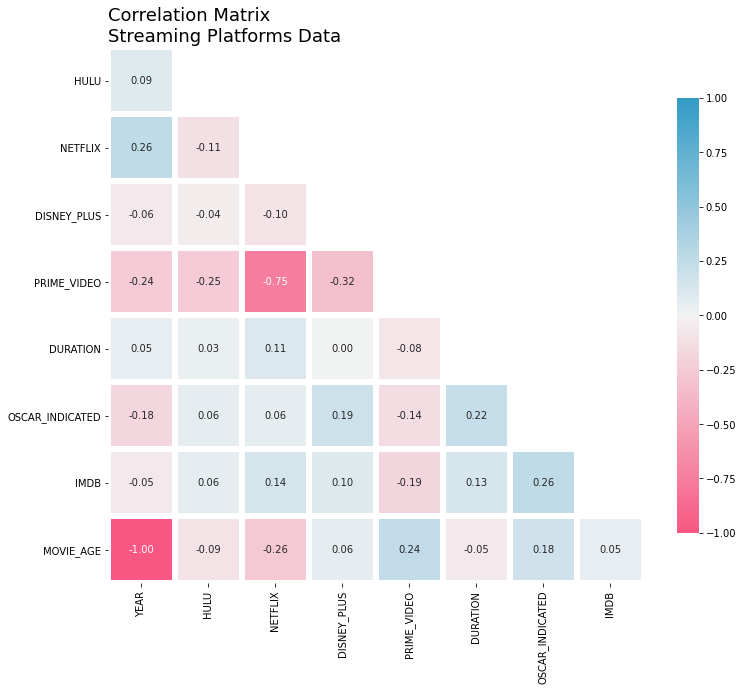

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))

# mask
mask = np.triu(np.ones_like(enriched_dataframe_corr, dtype=np.bool))

# adjust mask and df
mask = mask[1:, :-1]
corr = enriched_dataframe_corr.iloc[1:,:-1].copy()

# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'Correlation Matrix\nStreaming Platforms Data'
plt.title(title, loc='left', fontsize=18)
plt.show()